In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad 

In [2]:
#Define final time, time step and epsilon
T = 1
dt = 0.0001
epsilon = 0
Nt = int(np.ceil(T/dt))

In [3]:
def plus(x,n):
    return x**n*(x>=0)

In [4]:
#Define cubic spline through the plus functions, ensure the compact support is enforced aswell, particularly important for t>(i+2)*dt 
def cubic_spline(t,dt,i):
    ans = (plus((t-(i-2)*dt),3)-4*plus((t-(i-1)*dt),3)+6*plus((t-(i)*dt),3)-4*plus((t-(i+1)*dt),3)+plus((t-(i+2)*dt),3))*(t<=(i+2)*dt)*(t>=(i-2)*dt)
    return 1/(4*dt**3)*ans

def deriv_cubic_spline(t,dt,i):
    ans = (3*plus((t-(i-2)*dt),2)-12*plus((t-(i-1)*dt),2)+18*plus((t-(i)*dt),2)-12*plus((t-(i+1)*dt),2)+3*plus((t-(i+2)*dt),2))*(t<=(i+2)*dt)*(t>=(i-2)*dt)
    return 1/(4*dt**3)*ans

#Same for second derivative
def second_deriv_cubic_spline(t,dt,i):
    ans = (6*plus(t-(i-2)*dt,1)-24*plus(t-(i-1)*dt,1)+36*plus(t-i*dt,1)-24*plus(t-(i+1)*dt,1)+6*plus(t-(i+2)*dt,1))*(t<=(i+2)*dt)*(t>=(i-2)*dt)
    return 1/(4*dt**3)*ans

def third_deriv_cubic_spline(t,dt,i):
    ans = (6*plus(t-(i-2)*dt,0)-24*plus(t-(i-1)*dt,0)+36*plus(t-i*dt,0)-24*plus(t-(i+1)*dt,0)+6*plus(t-(i+2)*dt,0))*(t<=(i+2)*dt)*(t>=(i-2)*dt)
    return 1/(4*dt**3)*ans

In [5]:
#Compute mass matrix coefficients
M_i_i = np.ones(Nt-1)*quad(lambda x: cubic_spline(x,dt,2)*cubic_spline(x,dt,2),0,4*dt,points=[dt,2*dt,3*dt])[0]
M_i_i_plus_1 = np.ones(Nt-2)*quad(lambda x: cubic_spline(x,dt,2)*cubic_spline(x,dt,3),dt,4*dt,points=[2*dt,3*dt])[0]
M_i_i_plus_2 = np.ones(Nt-3)*quad(lambda x: cubic_spline(x,dt,2)*cubic_spline(x,dt,4),2*dt,4*dt,points=[3*dt])[0]
M_i_i_plus_3 = np.ones(Nt-4)*quad(lambda x: cubic_spline(x,dt,2)*cubic_spline(x,dt,5),3*dt,4*dt)[0]
M_i_plus_1_i = np.ones(Nt-1)*quad(lambda x: cubic_spline(x,dt,1)*cubic_spline(x,dt,2),0,3*dt,points=[dt,2*dt])[0]
M_i_plus_2_i = np.ones(Nt-1)*quad(lambda x: cubic_spline(x,dt,0)*cubic_spline(x,dt,2),0,2*dt,points=[dt])[0]
M_i_plus_3_i = np.ones(Nt-1)*quad(lambda x: cubic_spline(x,dt,-1)*cubic_spline(x,dt,2),0,dt)[0]

M_i_i[-1] = quad(lambda x: cubic_spline(x,dt,2)*cubic_spline(x,dt,2),0,2*dt,points=[dt])[0]
M_i_i[-2] = quad(lambda x: cubic_spline(x,dt,2)*cubic_spline(x,dt,2),0,3*dt,points=[dt,2*dt])[0]

M_i_i_plus_1[-1] = quad(lambda x: cubic_spline(x,dt,2)*cubic_spline(x,dt,3),dt,3*dt,points=[2*dt])[0]
M_i_plus_1_i[-1] = quad(lambda x: cubic_spline(x,dt,1)*cubic_spline(x,dt,2),0,2*dt,points=[dt])[0]

In [6]:
M = np.zeros([Nt-1,Nt+1])
np.fill_diagonal(M[:,2:],M_i_i)
np.fill_diagonal(M[:,3:],M_i_i_plus_1)
np.fill_diagonal(M[:,4:],M_i_i_plus_2)
np.fill_diagonal(M[:,5:],M_i_i_plus_3)

np.fill_diagonal(M[:,1:],M_i_plus_1_i)
np.fill_diagonal(M,M_i_plus_2_i)
np.fill_diagonal(M[1:],M_i_plus_3_i)

In [7]:
M[0,-1] = M_i_i_plus_3[0]
M[-1,0] = M_i_i_plus_3[0]

In [8]:
A = np.zeros([Nt-1,Nt+1])


A_i_i = np.ones(Nt-1)*quad(lambda x: second_deriv_cubic_spline(x,dt,2)*(epsilon**2*second_deriv_cubic_spline(x,dt,2)+2*epsilon*deriv_cubic_spline(x,dt,2)+cubic_spline(x,dt,2)),0,4*dt,points=[dt,2*dt,3*dt])[0]
A_i_i_plus_1 = np.ones(Nt-2)*quad(lambda x: (epsilon**2*second_deriv_cubic_spline(x,dt,2)+2*epsilon*deriv_cubic_spline(x,dt,2)+cubic_spline(x,dt,2))*second_deriv_cubic_spline(x,dt,3),dt,4*dt,points=[2*dt,3*dt])[0]
A_i_i_plus_2 = np.ones(Nt-3)*quad(lambda x: (epsilon**2*second_deriv_cubic_spline(x,dt,2)+2*epsilon*deriv_cubic_spline(x,dt,2)+cubic_spline(x,dt,2))*second_deriv_cubic_spline(x,dt,4),2*dt,4*dt,points=[3*dt])[0]
A_i_i_plus_3 = np.ones(Nt-4)*quad(lambda x: (epsilon**2*second_deriv_cubic_spline(x,dt,2)+2*epsilon*deriv_cubic_spline(x,dt,2)+cubic_spline(x,dt,2))*second_deriv_cubic_spline(x,dt,5),3*dt,4*dt)[0]
A_i_plus_1_i = np.ones(Nt-1)*quad(lambda x: (epsilon**2*second_deriv_cubic_spline(x,dt,1)+2*epsilon*deriv_cubic_spline(x,dt,1)+cubic_spline(x,dt,1))*second_deriv_cubic_spline(x,dt,2),0,3*dt,points=[dt,2*dt])[0]
A_i_plus_2_i = np.ones(Nt-1)*quad(lambda x: (epsilon**2*second_deriv_cubic_spline(x,dt,0)+2*epsilon*deriv_cubic_spline(x,dt,0)+cubic_spline(x,dt,0))*second_deriv_cubic_spline(x,dt,2),0,2*dt,points=[dt])[0]
A_i_plus_3_i = np.ones(Nt-1)*quad(lambda x: (epsilon**2*second_deriv_cubic_spline(x,dt,-1)+2*epsilon*deriv_cubic_spline(x,dt,-1)+cubic_spline(x,dt,-1))*second_deriv_cubic_spline(x,dt,2),0,dt)[0]


A_i_i[-1] = quad(lambda x: cubic_spline(x,dt,2)*cubic_spline(x,dt,2),0,2*dt,points=[dt])[0]
A_i_i[-2] = quad(lambda x: cubic_spline(x,dt,2)*cubic_spline(x,dt,2),0,3*dt,points=[dt,2*dt])[0]

A_i_i_plus_1[-1] = quad(lambda x: cubic_spline(x,dt,2)*cubic_spline(x,dt,3),dt,3*dt,points=[2*dt])[0]
A_i_plus_1_i[-1] = quad(lambda x: cubic_spline(x,dt,1)*cubic_spline(x,dt,2),0,2*dt,points=[dt])[0]


In [9]:
np.fill_diagonal(A[:,2:],A_i_i)
np.fill_diagonal(A[:,3:],A_i_i_plus_1)
np.fill_diagonal(A[:,4:],A_i_i_plus_2)
np.fill_diagonal(A[:,5:],A_i_i_plus_3)

np.fill_diagonal(A[:,1:],A_i_plus_1_i)
np.fill_diagonal(A,A_i_plus_2_i)
np.fill_diagonal(A[1:],A_i_plus_3_i)


In [10]:
lambd = np.pi**2*16
Mat_interior = A+lambd*M

In [11]:
init_conds = np.zeros([2,Nt+1])
init_conds[0,0] = 1
init_conds[0,1] = 1/4
init_conds[1,1] = 3/(4*dt)

In [12]:
Full_system  = np.block([[init_conds],[Mat_interior]])

In [13]:
u0 = 0
u1 = 1

F = np.zeros(Nt+1)
F[0] = u0
F[1] = u1

sigma = np.linalg.solve(Full_system,F)

In [14]:
#Define basis projection
def cubic_interpolant(t,dt):
    sum = 0
    for j in range(len(sigma)):
        sum += sigma[j]*cubic_spline(t,dt,j)
    return sum

def deriv_interpolant(t,dt):
    sum = 0
    for j in range(len(sigma)):
        sum += sigma[j]*deriv_cubic_spline(t,dt,j)
    return sum

#True solution
def true_sol(t,y0,y0_prime,lambd):
    return y0*np.cos(np.sqrt(lambd)*t)+y0_prime/np.sqrt(lambd)*np.sin(np.sqrt(lambd)*t)

def true_deriv(t,y0,y0_prime,lambd):
    return -np.sqrt(lambd)*y0*np.sin(np.sqrt(lambd)*t)+y0_prime*np.cos(np.sqrt(lambd)*t)

Text(0.5, 1.0, 'Cubic spline, $u^0$ = 0, $u^1$ = 1, T=1, eps = 0, dt = 0.0001')

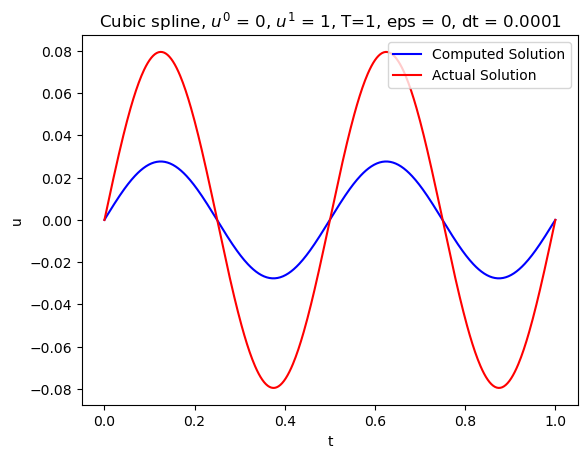

In [15]:
#Plot some outputs

t = np.linspace(0,T,501)
computed_solution = cubic_interpolant(t,dt)
plt.plot(t,computed_solution,label='Computed Solution',color='b')
plt.plot(t,true_sol(t,u0,u1,lambd),label='Actual Solution',color = 'r')
plt.legend()
plt.ylabel('u')
plt.xlabel('t')
plt.title("Cubic spline, " + r"$u^0$ = {}, $u^1$ = {}, T={}, eps = {}, dt = {}".format(u0,u1,T,epsilon,dt))


Text(0.5, 1.0, 'Derivative, $u^0$ = 0, $u^1$ = 1, T=1, eps = 0, dt = 0.0001')

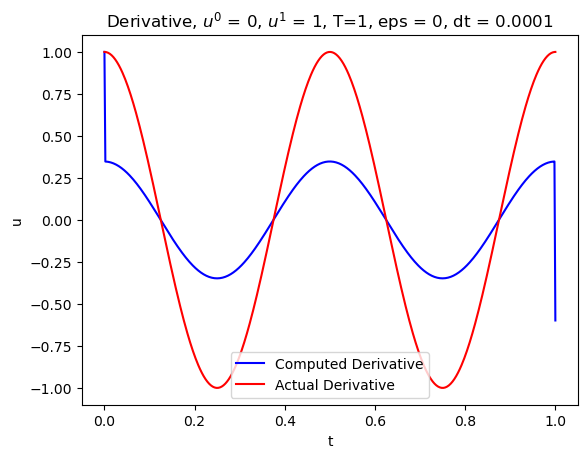

In [16]:
#Plot some outputs

t = np.linspace(0,T,501)
computed_deriv_solution = deriv_interpolant(t,dt)
plt.plot(t,computed_deriv_solution,label='Computed Derivative',color='b')
plt.plot(t,true_deriv(t,u0,u1,lambd),label='Actual Derivative',color = 'r')
plt.legend()
plt.ylabel('u')
plt.xlabel('t')
plt.title("Derivative, " +r"$u^0$ = {}, $u^1$ = {}, T={}, eps = {}, dt = {}".format(u0,u1,T,epsilon,dt))


Text(0.5, 1.0, 'Derivative, $u^0$ = 0, $u^1$ = 1, T=1, eps = 0, dt = 0.0001')

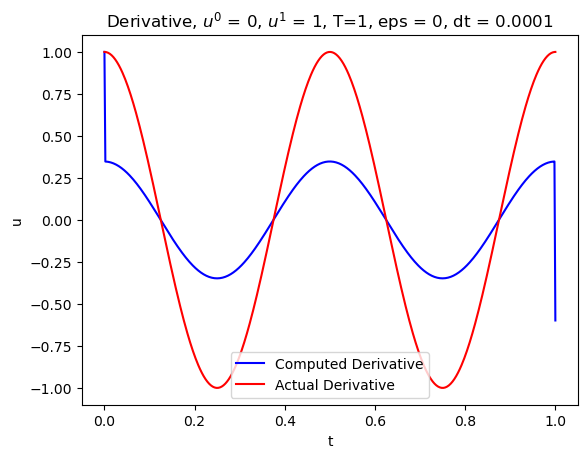

In [17]:
#Plot some outputs

t = np.linspace(0,T,501)
computed_deriv_solution = deriv_interpolant(t,dt)
plt.plot(t,computed_deriv_solution,label='Computed Derivative',color='b')
plt.plot(t,true_deriv(t,u0,u1,lambd),label='Actual Derivative',color = 'r')
plt.legend()
plt.ylabel('u')
plt.xlabel('t')
plt.title("Derivative, " +r"$u^0$ = {}, $u^1$ = {}, T={}, eps = {}, dt = {}".format(u0,u1,T,epsilon,dt))
